# Experimentos de Deep Learning - Food Image Classification (Local)

Este notebook contém experimentos completos para rodar localmente no Jupyter, utilizando o dataset Food-101 do arquivo `archive (1).zip`.

## Experimentos incluídos:

1. **Extração e exploração do dataset**
2. **Preparação e pré-processamento dos dados**
3. **Classificação de imagens com CNN simples**
4. **Transfer Learning com modelos pré-treinados**
5. **Análise de resultados e visualizações**


In [ ]:
# Instalar dependências necessárias (execute esta célula primeiro se houver erros de importação)
import sys
import subprocess

def install_package(package):
    """Instala um pacote usando pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# Lista de pacotes necessários
packages = [
    "numpy",
    "pandas", 
    "matplotlib",
    "seaborn",
    "pillow",
    "scikit-learn"
]

print("Verificando e instalando dependências...")
for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} já instalado")
    except ImportError:
        print(f"Instalando {package}...")
        install_package(package)
        print(f"✓ {package} instalado com sucesso")

print("\nTodas as dependências estão prontas!")


Verificando e instalando dependências...
✓ numpy já instalado
✓ pandas já instalado
✓ matplotlib já instalado
✓ seaborn já instalado
Instalando pillow...


In [ ]:
# Importações necessárias
import os
import zipfile
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Tentar importar TensorFlow (opcional - pode não estar disponível)
try:
    import tensorflow as tf
    # TensorFlow 2.20+ - usar tf_keras (mais compatível)
    try:
        from tf_keras import layers, optimizers, callbacks
        import tf_keras as keras
        from tf_keras.preprocessing.image import ImageDataGenerator
        print("✓ Usando tf_keras")
    except ImportError:
        # Fallback - tentar keras normal
        try:
            import keras
            from keras import layers, optimizers, callbacks
            from keras.preprocessing.image import ImageDataGenerator
            keras.config.set_backend('tensorflow')
            print("✓ Usando keras com backend tensorflow")
        except:
            # Último recurso
            keras = tf.keras
            layers = tf.keras.layers
            optimizers = tf.keras.optimizers
            callbacks = tf.keras.callbacks
            from tensorflow.keras.preprocessing.image import ImageDataGenerator
            print("✓ Usando tf.keras diretamente")
    
    TENSORFLOW_AVAILABLE = True
    print(f"✓ TensorFlow version: {tf.__version__}")
    try:
        print(f"✓ Keras version: {keras.__version__}")
    except:
        pass
    print(f"✓ GPUs disponíveis: {len(tf.config.list_physical_devices('GPU'))}")
    if tf.config.list_physical_devices('GPU'):
        print("✓ GPU detectada! Treinamento será acelerado.")
    else:
        print("ℹ Usando CPU. Treinamento pode ser mais lento.")
    # Teste rápido
    test_model = keras.Sequential([layers.Dense(1)])
    print("✓ TensorFlow e Keras funcionando corretamente!")
except ImportError as e:
    TENSORFLOW_AVAILABLE = False
    print(f"⚠ TensorFlow não disponível: {e}")
    print("⚠ Você pode executar as células de exploração de dados, mas não poderá treinar modelos.")
    print("⚠ Para instalar TensorFlow, execute: pip install tensorflow tf_keras")
except Exception as e:
    TENSORFLOW_AVAILABLE = False
    print(f"⚠ Erro ao inicializar TensorFlow: {e}")
    print("⚠ Você pode executar as células de exploração de dados, mas não poderá treinar modelos.")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configurações
SEED = 42
np.random.seed(SEED)
if TENSORFLOW_AVAILABLE:
    tf.random.set_seed(SEED)

print(f"\n✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Matplotlib version: {plt.matplotlib.__version__}")
print("\n✓ Todas as importações básicas concluídas!")


⚠ TensorFlow não disponível: No module named 'tensorflow'
⚠ Você pode executar as células de exploração de dados, mas não poderá treinar modelos.
⚠ Para instalar TensorFlow, execute: pip install tensorflow

✓ NumPy version: 2.3.5
✓ Pandas version: 2.3.3
✓ Matplotlib version: 3.10.7

✓ Todas as importações básicas concluídas!


## 1. Extração e Configuração do Dataset


In [ ]:
# Configuração de caminhos
BASE_DIR = Path.cwd()
ZIP_FILE = BASE_DIR / "archive (1).zip"
ARCHIVE_DIR = BASE_DIR / "archive (1)"
IMAGES_DIR_ARCHIVE = ARCHIVE_DIR / "images"
META_DIR = ARCHIVE_DIR / "meta" / "meta"

# Verificar se há dataset alternativo
FOOD_DATASET_DIR = BASE_DIR / "Food Classification dataset"

# Priorizar dataset alternativo se existir, senão usar archive
if FOOD_DATASET_DIR.exists() and FOOD_DATASET_DIR.is_dir():
    IMAGES_DIR = FOOD_DATASET_DIR
    print(f"✓ Usando dataset alternativo: {FOOD_DATASET_DIR}")
elif IMAGES_DIR_ARCHIVE.exists():
    IMAGES_DIR = IMAGES_DIR_ARCHIVE
    print(f"✓ Usando dataset do archive: {IMAGES_DIR_ARCHIVE}")
else:
    # Tentar extrair do zip se necessário
    if ZIP_FILE.exists():
        print("Extraindo arquivo zip...")
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
        print("Extração concluída!")
        IMAGES_DIR = IMAGES_DIR_ARCHIVE
    else:
        IMAGES_DIR = None
        print(f"⚠️ Nenhum dataset de imagens encontrado!")

# Verificar estrutura
print(f"\nDiretório base: {BASE_DIR}")
if IMAGES_DIR:
    print(f"✓ Pasta de imagens: {IMAGES_DIR}")
    print(f"✓ Pasta de imagens existe: {IMAGES_DIR.exists()}")
    if IMAGES_DIR.exists():
        class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
        print(f"✓ Classes encontradas: {len(class_dirs)}")
else:
    print(f"⚠️ Pasta de imagens não encontrada!")

print(f"Pasta de metadados existe: {META_DIR.exists()}")


✓ Usando dataset alternativo: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\Food Classification dataset

Diretório base: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4
✓ Pasta de imagens: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\Food Classification dataset
✓ Pasta de imagens existe: True
✓ Classes encontradas: 34
Pasta de metadados existe: True


## 2. Exploração do Dataset


In [ ]:
# Carregar classes
if META_DIR.exists():
    classes_file = META_DIR / "classes.txt"
    if classes_file.exists():
        with open(classes_file, 'r', encoding='utf-8') as f:
            classes = [line.strip() for line in f.readlines()]
        print(f"✓ Total de classes no arquivo: {len(classes)}")
        print(f"\nPrimeiras 10 classes: {classes[:10]}")
    else:
        print("⚠️ Arquivo classes.txt não encontrado!")
        classes = []
else:
    classes = []

# Explorar estrutura de imagens
if IMAGES_DIR and IMAGES_DIR.exists():
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    print(f"\n✓ Total de pastas de classes encontradas: {len(class_dirs)}")
    
    # Contar imagens por classe (suporta .jpg, .JPG, .jpeg, .png)
    class_counts = {}
    total_images = 0
    
    for class_dir in class_dirs:
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))
        count = len(images)
        class_counts[class_dir.name] = count
        total_images += count
    
    print(f"\n✓ Total de imagens no dataset: {total_images:,}")
    print(f"\nNúmero de imagens por classe (primeiras 15):")
    for i, (cls, count) in enumerate(list(class_counts.items())[:15]):
        print(f"  {i+1}. {cls}: {count} imagens")
    
    # Estatísticas
    if class_counts:
        avg_images = total_images / len(class_counts)
        max_images = max(class_counts.values())
        min_images = min(class_counts.values())
        print(f"\n📊 Estatísticas:")
        print(f"  - Média de imagens por classe: {avg_images:.1f}")
        print(f"  - Máximo: {max_images} imagens")
        print(f"  - Mínimo: {min_images} imagens")
    
    # Criar lista de classes disponíveis no dataset
    classes_disponiveis = list(class_counts.keys())
    print(f"\n✓ Classes disponíveis no dataset: {len(classes_disponiveis)}")
    
else:
    print("⚠️ Pasta de imagens não encontrada!")
    class_counts = {}
    classes_disponiveis = []


✓ Total de classes no arquivo: 101

Primeiras 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']

✓ Total de pastas de classes encontradas: 34

✓ Total de imagens no dataset: 35,931

Número de imagens por classe (primeiras 15):
  1. apple_pie: 2000 imagens
  2. Baked Potato: 1500 imagens
  3. burger: 662 imagens
  4. butter_naan: 614 imagens
  5. chai: 688 imagens
  6. chapati: 654 imagens
  7. cheesecake: 2000 imagens
  8. chicken_curry: 2000 imagens
  9. chole_bhature: 752 imagens
  10. Crispy Chicken: 1500 imagens
  11. dal_makhani: 590 imagens
  12. dhokla: 490 imagens
  13. Donut: 1555 imagens
  14. fried_rice: 698 imagens
  15. Fries: 1500 imagens

📊 Estatísticas:
  - Média de imagens por classe: 1056.8
  - Máximo: 2000 imagens
  - Mínimo: 288 imagens

✓ Classes disponíveis no dataset: 34


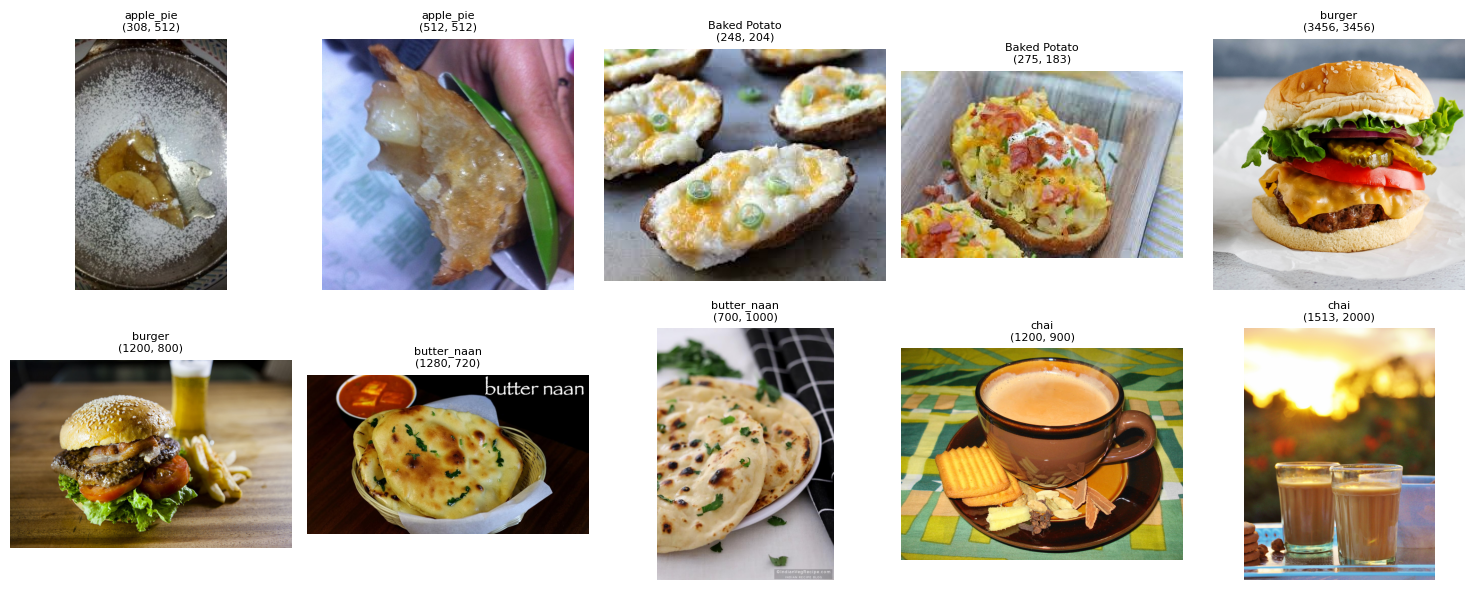


✓ Visualização de 10 imagens de exemplo


In [ ]:
# Visualizar algumas imagens de exemplo
if IMAGES_DIR and IMAGES_DIR.exists():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()][:5]
    idx = 0
    
    for class_dir in class_dirs:
        # Buscar imagens em diferentes formatos
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))[:2]
        for img_path in images:
            if idx < 10:
                try:
                    img = Image.open(img_path)
                    axes[idx].imshow(img)
                    axes[idx].set_title(f"{class_dir.name}\n{img.size}", fontsize=8)
                    axes[idx].axis('off')
                    idx += 1
                except Exception as e:
                    print(f"Erro ao carregar {img_path}: {e}")
    
    # Ocultar eixos não usados
    for i in range(idx, 10):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualização de {idx} imagens de exemplo")
else:
    print("⚠️ Não foi possível visualizar imagens - dataset não encontrado")


## 3. Preparação dos Dados


In [ ]:
# Configurações para preparação dos dados
IMG_SIZE = 224  # Tamanho padrão para modelos pré-treinados
BATCH_SIZE = 32

# Para experimentos mais rápidos, vamos usar um subconjunto das classes
# Altere este valor para usar mais ou menos classes
SUBSET_CLASSES = 10  # Usar apenas 10 classes para treinamento mais rápido

# Usar classes disponíveis no dataset se existir, senão usar classes do arquivo
if 'classes_disponiveis' in locals() and classes_disponiveis:
    # Filtrar apenas classes que existem no dataset
    if classes:
        # Mapear nomes (pode ter diferenças de capitalização)
        selected_classes = []
        for cls in classes[:SUBSET_CLASSES]:
            # Buscar correspondência (case-insensitive)
            found = None
            for available_cls in classes_disponiveis:
                if cls.lower() == available_cls.lower() or cls.lower().replace('_', ' ') == available_cls.lower().replace('_', ' '):
                    found = available_cls
                    break
            if found:
                selected_classes.append(found)
            elif len(selected_classes) < SUBSET_CLASSES:
                # Se não encontrou, usar uma classe disponível
                if classes_disponiveis:
                    selected_classes.append(classes_disponiveis[len(selected_classes)])
    else:
        selected_classes = classes_disponiveis[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"✓ Usando {len(selected_classes)} classes disponíveis no dataset para treinamento:")
    for i, cls in enumerate(selected_classes, 1):
        print(f"  {i}. {cls}")
elif classes:
    selected_classes = classes[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"⚠️ Usando classes do arquivo (pode não corresponder ao dataset):")
    print(selected_classes)
else:
    selected_classes = []
    NUM_CLASSES = 0
    print("⚠️ Nenhuma classe disponível!")


✓ Usando 10 classes disponíveis no dataset para treinamento:
  1. apple_pie
  2. Baked Potato
  3. burger
  4. butter_naan
  5. chai
  6. chapati
  7. cheesecake
  8. chicken_curry
  9. chole_bhature
  10. Crispy Chicken


In [ ]:
# Função para carregar dados usando ImageDataGenerator
if TENSORFLOW_AVAILABLE:
    def create_data_generators(images_dir, selected_classes, img_size=224, batch_size=32, validation_split=0.2):
        """
        Cria geradores de dados para treino e validação
        """
        # Data augmentation para treino
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            validation_split=validation_split
        )
        
        # Apenas normalização para validação
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split
        )
        
        # Criar geradores
        train_generator = train_datagen.flow_from_directory(
            images_dir,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training',
            classes=selected_classes,
            seed=SEED
        )
        
        val_generator = val_datagen.flow_from_directory(
            images_dir,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            classes=selected_classes,
            seed=SEED
        )
        
        return train_generator, val_generator

    # Criar geradores se TensorFlow estiver disponível
    if IMAGES_DIR and IMAGES_DIR.exists() and selected_classes:
        try:
            train_gen, val_gen = create_data_generators(
                IMAGES_DIR, 
                selected_classes, 
                IMG_SIZE, 
                BATCH_SIZE
            )
            
            print(f"✓ Classes encontradas: {list(train_gen.class_indices.keys())}")
            print(f"✓ Número de amostras de treino: {train_gen.samples}")
            print(f"✓ Número de amostras de validação: {val_gen.samples}")
            print(f"✓ Número de classes: {train_gen.num_classes}")
        except Exception as e:
            print(f"⚠️ Erro ao criar geradores: {e}")
            train_gen = None
            val_gen = None
    else:
        print("⚠️ Não foi possível criar os geradores de dados!")
        print(f"   - IMAGES_DIR existe: {IMAGES_DIR.exists()}")
        print(f"   - Classes selecionadas: {len(selected_classes) if selected_classes else 0}")
        train_gen = None
        val_gen = None
else:
    print("⚠️ TensorFlow não está disponível!")
    print("⚠️ Não é possível criar geradores de dados sem TensorFlow.")
    print("⚠️ Você pode executar as células de exploração de dados, mas não poderá treinar modelos.")
    train_gen = None
    val_gen = None


⚠️ TensorFlow não está disponível!
⚠️ Não é possível criar geradores de dados sem TensorFlow.
⚠️ Você pode executar as células de exploração de dados, mas não poderá treinar modelos.


## 4. Modelo CNN Simples


In [ ]:
def create_simple_cnn(input_shape=(224, 224, 3), num_classes=10):
    """
    Cria uma CNN simples para classificação de imagens
    """
    model = keras.Sequential([
        # Primeira camada convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        
        # Segunda camada convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Terceira camada convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Quarta camada convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        # Flatten e camadas densas
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

if 'train_gen' in locals():
    num_classes = train_gen.num_classes
    simple_model = create_simple_cnn((IMG_SIZE, IMG_SIZE, 3), num_classes)
    
    simple_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Arquitetura do modelo CNN simples:")
    simple_model.summary()


AttributeError: 'NoneType' object has no attribute 'num_classes'

In [ ]:
# Treinar modelo CNN simples
if 'simple_model' in locals() and 'train_gen' in locals():
    print("Iniciando treinamento do modelo CNN simples...")
    print("⚠️ Este processo pode demorar. Ajuste EPOCHS se necessário.")
    
    EPOCHS = 10  # Reduza este número para treinamento mais rápido
    
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.0001
    )
    
    history_simple = simple_model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("\n✅ Treinamento concluído!")
else:
    print("⚠️ Modelo ou geradores não foram criados!")


⚠️ Modelo ou geradores não foram criados!


In [ ]:
# Visualizar histórico de treinamento - CNN Simples
if 'history_simple' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history_simple.history['accuracy'], label='Treino')
    axes[0].plot(history_simple.history['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia - CNN Simples')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history_simple.history['loss'], label='Treino')
    axes[1].plot(history_simple.history['val_loss'], label='Validação')
    axes[1].set_title('Loss - CNN Simples')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Avaliar no conjunto de validação
    val_loss, val_acc = simple_model.evaluate(val_gen, verbose=0)
    print(f"\nAcurácia final na validação: {val_acc:.4f}")
    print(f"Loss final na validação: {val_loss:.4f}")


## 5. Transfer Learning com MobileNetV2


In [ ]:
def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=10):
    """
    Cria um modelo usando Transfer Learning com MobileNetV2
    """
    # Carregar MobileNetV2 pré-treinado (sem a camada de classificação)
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Congelar camadas base (opcional - pode descongelar para fine-tuning)
    base_model.trainable = False
    
    # Adicionar camadas de classificação
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

if 'train_gen' in locals():
    num_classes = train_gen.num_classes
    transfer_model = create_transfer_learning_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
    
    transfer_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Arquitetura do modelo com Transfer Learning:")
    transfer_model.summary()


In [ ]:
# Treinar modelo com Transfer Learning
if 'transfer_model' in locals() and 'train_gen' in locals():
    print("Iniciando treinamento do modelo com Transfer Learning...")
    print("⚠️ Este processo pode demorar. Ajuste EPOCHS se necessário.")
    
    EPOCHS_TL = 10  # Reduza este número para treinamento mais rápido
    
    # Callbacks
    early_stopping_tl = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    reduce_lr_tl = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.00001
    )
    
    history_transfer = transfer_model.fit(
        train_gen,
        epochs=EPOCHS_TL,
        validation_data=val_gen,
        callbacks=[early_stopping_tl, reduce_lr_tl],
        verbose=1
    )
    
    print("\n✅ Treinamento concluído!")
else:
    print("⚠️ Modelo ou geradores não foram criados!")


⚠️ Modelo ou geradores não foram criados!


In [ ]:
# Visualizar histórico de treinamento - Transfer Learning
if 'history_transfer' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    axes[0].plot(history_transfer.history['accuracy'], label='Treino')
    axes[0].plot(history_transfer.history['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia - Transfer Learning')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history_transfer.history['loss'], label='Treino')
    axes[1].plot(history_transfer.history['val_loss'], label='Validação')
    axes[1].set_title('Loss - Transfer Learning')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Avaliar no conjunto de validação
    val_loss_tl, val_acc_tl = transfer_model.evaluate(val_gen, verbose=0)
    print(f"\nAcurácia final na validação: {val_acc_tl:.4f}")
    print(f"Loss final na validação: {val_loss_tl:.4f}")


## 6. Comparação de Modelos


In [ ]:
# Comparar performance dos modelos
if 'history_simple' in locals() and 'history_transfer' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Comparar accuracy
    axes[0].plot(history_simple.history['val_accuracy'], label='CNN Simples', marker='o')
    axes[0].plot(history_transfer.history['val_accuracy'], label='Transfer Learning', marker='s')
    axes[0].set_title('Comparação de Acurácia na Validação')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)
    
    # Comparar loss
    axes[1].plot(history_simple.history['val_loss'], label='CNN Simples', marker='o')
    axes[1].plot(history_transfer.history['val_loss'], label='Transfer Learning', marker='s')
    axes[1].set_title('Comparação de Loss na Validação')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Resumo numérico
    print("\n" + "="*50)
    print("RESUMO DE PERFORMANCE")
    print("="*50)
    print(f"\nCNN Simples:")
    print(f"  Acurácia final: {max(history_simple.history['val_accuracy']):.4f}")
    print(f"  Loss final: {min(history_simple.history['val_loss']):.4f}")
    print(f"\nTransfer Learning:")
    print(f"  Acurácia final: {max(history_transfer.history['val_accuracy']):.4f}")
    print(f"  Loss final: {min(history_transfer.history['val_loss']):.4f}")
    print("="*50)


## 7. Teste com Imagens de Exemplo


In [ ]:
# Função para fazer predições em imagens
def predict_image(model, img_path, class_names, img_size=224):
    """
    Faz predição em uma única imagem
    """
    img = Image.open(img_path)
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    return img, class_names[predicted_class_idx], confidence, predictions[0]

# Testar com algumas imagens do conjunto de validação
if 'transfer_model' in locals() and 'val_gen' in locals() and IMAGES_DIR.exists():
    # Pegar algumas imagens aleatórias
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    class_names = list(val_gen.class_indices.keys())
    
    # Pegar uma imagem de cada classe disponível
    for idx, class_name in enumerate(class_names[:6]):
        class_dir = IMAGES_DIR / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg"))
            if images:
                img_path = images[0]
                img, pred_class, confidence, all_preds = predict_image(
                    transfer_model, img_path, class_names, IMG_SIZE
                )
                
                axes[idx].imshow(img)
                axes[idx].set_title(f"Real: {class_name}\nPredito: {pred_class}\nConfiança: {confidence:.2%}")
                axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Modelo ou geradores não disponíveis para teste!")


⚠️ Modelo ou geradores não disponíveis para teste!


## 8. Salvar Modelos (Opcional)


In [ ]:
# Salvar modelos treinados
MODELS_DIR = BASE_DIR / "modelos_salvos"
MODELS_DIR.mkdir(exist_ok=True)

if 'simple_model' in locals():
    simple_model_path = MODELS_DIR / "cnn_simples_food101.h5"
    simple_model.save(simple_model_path)
    print(f"✅ Modelo CNN simples salvo em: {simple_model_path}")

if 'transfer_model' in locals():
    transfer_model_path = MODELS_DIR / "transfer_learning_food101.h5"
    transfer_model.save(transfer_model_path)
    print(f"✅ Modelo Transfer Learning salvo em: {transfer_model_path}")

print(f"\nTodos os modelos salvos em: {MODELS_DIR}")



Todos os modelos salvos em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos


## Notas Finais

### Dicas para melhorar os resultados:

1. **Aumentar número de classes**: Altere `SUBSET_CLASSES` para usar mais classes
2. **Aumentar épocas**: Aumente `EPOCHS` e `EPOCHS_TL` para treinamento mais longo
3. **Fine-tuning**: Descongele algumas camadas do modelo base para fine-tuning
4. **Data Augmentation**: Ajuste os parâmetros de augmentation para mais diversidade
5. **Tamanho da imagem**: Experimente diferentes tamanhos (128, 256, etc.)
6. **Batch size**: Ajuste conforme sua memória disponível

### Próximos passos:

- Experimentar com outros modelos pré-treinados (ResNet, EfficientNet, etc.)
- Implementar ensemble de modelos
- Adicionar análise de matriz de confusão detalhada
- Implementar grad-CAM para visualização de atenção
